# Chapter 13

## Setup and Imports

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [4]:
nhefs_all = pd.read_excel('NHEFS.xls')

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [5]:
nhefs_all.shape

(1629, 64)

Add squared features as in chapter 12

In [6]:
for col in ['age', 'wt71', 'smokeintensity', 'smokeyrs']:
    nhefs_all['{}^2'.format(col)] = nhefs_all[col] * nhefs_all[col]

Add constant term. We'll call it `'one'` this time.

In [7]:
nhefs_all['one'] = 1

A column of zeros will also be useful later

In [8]:
nhefs_all['zero'] = 0

Add dummy features

In [9]:
edu_dummies = pd.get_dummies(nhefs_all.education, prefix='edu')
exercise_dummies = pd.get_dummies(nhefs_all.exercise, prefix='exercise')
active_dummies = pd.get_dummies(nhefs_all.active, prefix='active')

nhefs_all = pd.concat(
    [nhefs_all, edu_dummies, exercise_dummies, active_dummies],
    axis=1
)

Add interaction term

In [10]:
nhefs_all['qsmk_x_smokeintensity'] = nhefs_all.qsmk * nhefs_all.smokeintensity

## Section 13.1

In the last chapter we initially restricted the data to include rows where none of the following columns were missing.

In [11]:
restriction_cols = [
    'sex', 'age', 'race', 'wt82', 'ht', 'school', 'alcoholpy', 'smokeintensity'
]

In fact, it turns out only one of those columns, `wt82`, has missing values.

In [12]:
print("       column    # missing")
for col in restriction_cols:
    print("{:>15}     {:>2}".format(col, nhefs_all[col].isnull().sum()))

       column    # missing
            sex      0
            age      0
           race      0
           wt82     63
             ht      0
         school      0
      alcoholpy      0
 smokeintensity      0


In other words, the only missing values (in those columns) are for censored rows.

In [13]:
missing = nhefs_all.wt82.isnull()
nhefs_uncens = nhefs_all.loc[~missing]

In [14]:
nhefs_uncens.shape

(1566, 82)

## Section 13.2

In [15]:
table = nhefs_uncens.groupby('qsmk').agg({'qsmk': 'count'}).T
table.index = ['count']
table

qsmk,0,1
count,1163,403


### Program 13.1

Create the model to estimate $E[Y|A=a, C=0, L=l]$ for each combination of values of $A$ and $L$

In [16]:
y = nhefs_uncens.wt82_71
X = nhefs_uncens[[
    'one', 'qsmk', 'sex', 'race', 'edu_2', 'edu_3', 'edu_4', 'edu_5', 
    'exercise_1', 'exercise_2', 'active_1', 'active_2',
    'age', 'age^2', 'wt71', 'wt71^2',
    'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2',
    'qsmk_x_smokeintensity'
]]

In [17]:
ols = sm.OLS(y, X) 
res = ols.fit()
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
one,-1.5882,4.313,-0.368,0.713,-10.048,6.872
qsmk,2.5596,0.809,3.163,0.002,0.972,4.147
sex,-1.4303,0.469,-3.050,0.002,-2.350,-0.510
race,0.5601,0.582,0.963,0.336,-0.581,1.701
edu_2,0.7904,0.607,1.302,0.193,-0.400,1.981
edu_3,0.5563,0.556,1.000,0.317,-0.534,1.647
edu_4,1.4916,0.832,1.792,0.073,-0.141,3.124
edu_5,-0.1950,0.741,-0.263,0.793,-1.649,1.259
exercise_1,0.2960,0.535,0.553,0.580,-0.754,1.346
exercise_2,0.3539,0.559,0.633,0.527,-0.742,1.450


Look at an example prediction, for the subject with ID 24770

In [18]:
example = X.loc[nhefs_uncens.seqn == 24770]

In [19]:
example

,one,qsmk,sex,race,edu_2,edu_3,edu_4,edu_5,exercise_1,exercise_2,...,active_2,age,age^2,wt71,wt71^2,smokeintensity,smokeintensity^2,smokeyrs,smokeyrs^2,qsmk_x_smokeintensity
1581,1,0,0,0,0,0,1,0,1,0,...,0,26,676,111.58,12450.0964,15,225,12,144,0


In [20]:
res.predict(example)

1581    0.342157
dtype: float64

A quick look at mean and extremes of the **predicted** weight gain, across subjects

In [21]:
estimated_gain = res.predict(X)

In [22]:
print('   min     mean      max')
print('------------------------')
print('{:>6.2f}   {:>6.2f}   {:>6.2f}'.format(
    estimated_gain.min(),
    estimated_gain.mean(),
    estimated_gain.max()
))

   min     mean      max
------------------------
-10.88     2.64     9.88


A quick look at mean and extreme values for **actual** weight gain

In [23]:
print('   min     mean      max')
print('------------------------')
print('{:>6.2f}   {:>6.2f}   {:>6.2f}'.format(
    nhefs_uncens.wt82_71.min(),
    nhefs_uncens.wt82_71.mean(),
    nhefs_uncens.wt82_71.max()
))

   min     mean      max
------------------------
-41.28     2.64    48.54


A scatterplot of predicted vs actual

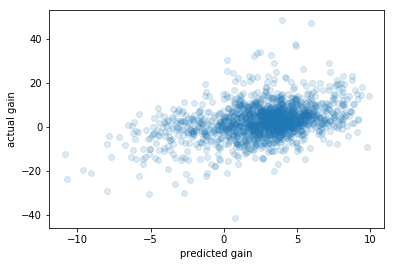

In [24]:
fix, ax = plt.subplots()

ax.scatter(estimated_gain, nhefs_uncens.wt82_71, alpha=0.15)
ax.set_xlabel('predicted gain')
ax.set_ylabel('actual gain');

## Section 13.3

### Program 13.2

The 4 steps to the method are
1. expansion of dataset
2. outcome modeling
3. prediction
4. standardization by averaging

I am going to use a few shortcuts. "Expansion of dataset" means creating the 3 blocks described in the text. The first block (the original data) is the only one that contributes to the model, so I'll just build the regression from the first block. The 2nd and 3rd blocks are only needed for predictions, so I'll only create them at prediction-time.

Thus my steps will look more like
1. outcome modeling, on the original data
2. prediction on expanded dataset
3. standardization by averaging

In [25]:
df = pd.DataFrame({
    'name': [
        "Rheia", "Kronos", "Demeter", "Hades", "Hestia", "Poseidon", 
        "Hera", "Zeus", "Artemis", "Apollo", "Leto", "Ares", "Athena", 
        "Hephaestus", "Aphrodite", "Cyclope", "Persephone", "Hermes", 
        "Hebe", "Dionysus"
    ],
    'L': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    'A': [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    'Y': [0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0]
})

df['A_x_L'] = df.A * df.L

df['zero'] = 0
df['one'] = 1

In [26]:
ols = sm.OLS(df.Y, df[['one', 'A', 'L', 'A_x_L']])
res = ols.fit()
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
one,0.2500,0.255,0.980,0.342,-0.291,0.791
A,-1.92e-17,0.361,-5.32e-17,1.000,-0.765,0.765
L,0.4167,0.390,1.069,0.301,-0.410,1.243
A_x_L,4.163e-17,0.496,8.39e-17,1.000,-1.051,1.051


<br>
Next make predictions from the second block, with all A = 0, which also makes A x L = 0.

"the average of all predicted values in the second block is precisely the standardized mean in the untreated"

In [27]:
A0_pred = res.predict(df[['one', 'zero', 'L', 'zero']])
print('standardized mean: {:>0.2f}'.format(A0_pred.mean()))

standardized mean: 0.50


<br>
Finally, make predictions from the third block, with all A = 1, which also makes A x L = L.

"To estimate the standardized mean outcome in the treated, we compute the average of all predicted values in the third block."

In [28]:
A1_pred = res.predict(df[['one', 'one', 'L', 'L']])
print('standardized mean: {:>0.2f}'.format(A1_pred.mean()))

standardized mean: 0.50


### Program 13.3

We repeat the steps done above, but for the `nhefs_all` data, using both censored and uncensored rows:

1. outcome modeling, on the original data
2. prediction on expanded dataset
3. standardization by averaging

Step 1: Outcome modeling on the `nhefs_all` data

Note: For convenience, I've moved `qsmk` to the end of the variable list, next to `qsmk_x_smokeintensity`.

In [29]:
# all input columns except qsmk and qsmk_x_smokeintensity
common_Xcols = [
    'one', 'sex', 'race', 'edu_2', 'edu_3', 'edu_4', 'edu_5', 
    'exercise_1', 'exercise_2', 'active_1', 'active_2',
    'age', 'age^2', 'wt71', 'wt71^2',
    'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2'
]

In [30]:
y = nhefs_uncens.wt82_71
X = nhefs_uncens[common_Xcols + ['qsmk', 'qsmk_x_smokeintensity']]

In [31]:
ols = sm.OLS(y, X) 
res = ols.fit()

In [32]:
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
one,-1.5882,4.313,-0.368,0.713,-10.048,6.872
sex,-1.4303,0.469,-3.050,0.002,-2.350,-0.510
race,0.5601,0.582,0.963,0.336,-0.581,1.701
edu_2,0.7904,0.607,1.302,0.193,-0.400,1.981
edu_3,0.5563,0.556,1.000,0.317,-0.534,1.647
edu_4,1.4916,0.832,1.792,0.073,-0.141,3.124
edu_5,-0.1950,0.741,-0.263,0.793,-1.649,1.259
exercise_1,0.2960,0.535,0.553,0.580,-0.754,1.346
exercise_2,0.3539,0.559,0.633,0.527,-0.742,1.450
active_1,-0.9476,0.410,-2.312,0.021,-1.752,-0.143


Step 2: Prediction on expanded dataset

In [33]:
block2 = nhefs_all[common_Xcols + ['zero', 'zero']]
# qsmk = 0, and thus qsmk_x_smokeintensity = 0

In [34]:
block2_pred = res.predict(block2)

In [35]:
block3 = nhefs_all[common_Xcols + ['one', 'smokeintensity']]
# qsmk = 1, and thus qsmk_x_smokeintensity = smokeintensity

In [36]:
block3_pred = res.predict(block3)

Step 3: Standardization by averaging

In [37]:
X_all = nhefs_all[common_Xcols + ['qsmk', 'qsmk_x_smokeintensity']]

orig_mean = res.predict(X_all).mean()
block2_mean = block2_pred.mean()
block3_mean = block3_pred.mean()
est_diff = block3_mean - block2_mean

print('original mean prediction: {:>0.2f}'.format(orig_mean))
print()
print(' block 2 mean prediction: {:>0.2f}'.format(block2_mean))
print(' block 3 mean prediction: {:>0.2f}'.format(block3_mean))
print()
print('  causal effect estimate: {:>0.2f}'.format(est_diff))

original mean prediction: 2.56

 block 2 mean prediction: 1.66
 block 3 mean prediction: 5.18

  causal effect estimate: 3.52


<br>
The model here in step 1 is the same as in Program 13.1, but the "block 1" mean prediction is different. Both models are fit on the uncensored rows, but the block means are over both censored and uncensored rows.

### Program 13.4

Use bootstrap to calculate the confidence interval on the previous estimate

If this runs too slowly, you can reduce the number of iterations in the `for` loop

In [38]:
boot_samples = []

for _ in range(2000):
    sample = nhefs_all.sample(n=nhefs_all.shape[0], replace=True)
    
    block2 = sample[common_Xcols + ['zero', 'zero']]
    block3 = sample[common_Xcols + ['one', 'smokeintensity']]
    
    uncens = sample.loc[~sample.wt82.isnull()]
    y = uncens.wt82_71
    X = uncens[common_Xcols + ['qsmk', 'qsmk_x_smokeintensity']]
    result = sm.OLS(y, X).fit()
    
    block2_pred = result.predict(block2)
    block3_pred = result.predict(block3)
    
    boot_samples.append(block3_pred.mean() - block2_pred.mean())

In [39]:
std = np.std(boot_samples)

In [40]:
lo = est_diff - 1.96 * std
hi = est_diff + 1.96 * std

print('               estimate   95% C.I.')
print('causal effect   {:>6.1f}   ({:>0.1f}, {:>0.1f})'.format(est_diff, lo, hi))

               estimate   95% C.I.
causal effect      3.5   (2.6, 4.5)


This confidence interval can be slightly different from the book values, because of bootstrap randomness